## Categorizing Clothing with CNN
In this project we explore the use of convolutional neural nets for image classification. Our dataset is a collection of 10 different types of clothing / accessories that we'll build a model to categorize. The goal of this notebook is to explore the initial dataset, fit a sequential CNN using keras, understand model parameters by testing their effect on model results, and finally, to evaluate the model's predictions and understand where it falls short. This notebook is 5-part:

1. Data Exploration
2. Modeling
3. Model Evaluation
4. Prediction

The comments in this notebook serve to orient the reader around the thought process taken during each step of the project. For a more in-depth explanation on convolutional neural nets and their applications, see my blog post here.

### 1. Data Exploration & Preprocessing
Here we import the dataset, do some light exploration to understand its attributes, and process the data for feeding into the model. Note that there is a uniform distribution across the 10 categories, and that all three shoe categories seem to contain images that are left-facing (toe pointing left). We will address the latter point in the modeling phase, when we use data augmentation to create more varied versions of these inputs.

Keras - the neural network library we will be using to construct our model - requires input vectors to have an extra dimension which correspond to their channels. Working with gray-scaled data, we only have one channel, so we reshape our train and test images to 28 x 28 x 1 3D matrices. Lastly, we create a validation dataset to evaluate our model's accuracy and watch for over/under-fitting during training.

In [240]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from collections import Counter
import time
import random

from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.datasets import mnist, fashion_mnist
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

np.random.seed(2)
sns.set(style='white', context='notebook',palette='mako')

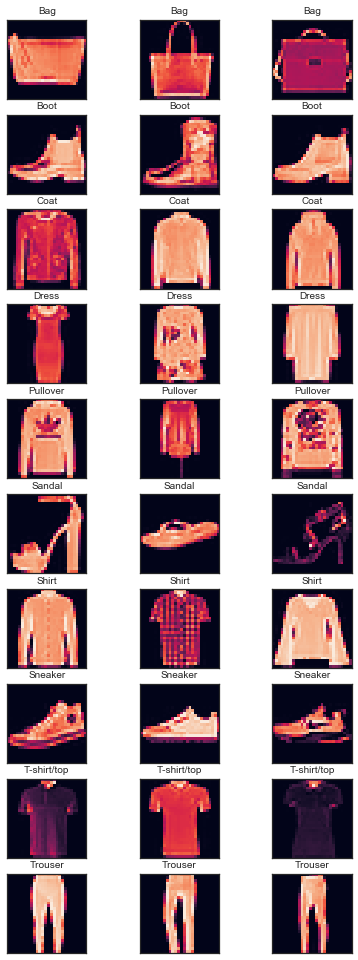

In [455]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

categories = {0: 'T-shirt/top',
             1: 'Trouser',
             2: 'Pullover',
             3: 'Dress',
             4: 'Coat',
             5: 'Sandal',
             6: 'Shirt',
             7: 'Sneaker',
             8: 'Bag',
             9: 'Boot'}

#plot random sample of each category
test = list(zip(x_train, [categories[x] for x in y_train]))
test_df = pd.DataFrame(test)

function = lambda obj: obj.loc[np.random.choice(obj.index, 3, False)]
grouped = test_df.groupby(1).apply(function)

fig, axes = plt.subplots(10, 3, figsize=(6,16))
axes = axes.flatten()
for i, image in enumerate(grouped[0]):
    axes[i].imshow(image)
    axes[i].set_title(grouped[1][i], size=10)
    axes[i].set_xticks([])
    axes[i].set_yticks([])

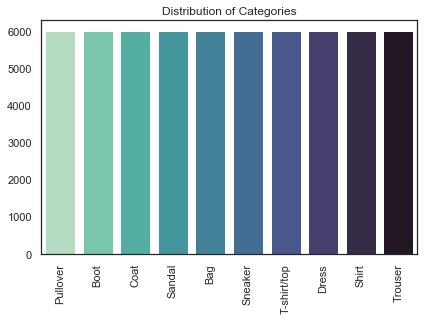

In [412]:
#plot distribution of categories
category_series = pd.Series(y_train).map(categories)
category_counts = category_series.value_counts()
sns.barplot(category_counts.index, category_counts, palette='mako_r')
ticks=plt.xticks(rotation='vertical')
title=plt.title('Distribution of Categories')

In [427]:
#check for nulls
print(f'Nulls in x_train: {np.isnan(x_train).sum()}')
print(f'Nulls in x_test: {np.isnan(x_test).sum()}')
print(f'Nulls in y_train: {np.isnan(y_train).sum()}')
print(f'Nulls in y_test: {np.isnan(y_test).sum()}')

Nulls in x_train: 0
Nulls in x_test: 0
Nulls in y_train: 0
Nulls in y_test: 0


In [237]:
#scaling to ease computational burden of model; CNN converges faster on [0,1] data than on [0,255]
#note: scaling does not change the way the image renders
x_train_scaled = x_train/255
x_test_scaled = x_test/255

#convert to float32, float64 uses twice as much memory
x_train_scaled_32 = x_train_scaled.astype('float32')
x_test_scaled_32 = x_test_scaled.astype('float32')

#reshape to 4d array with expected input shape of (batch, rows, columns, channels) for keras
#since images are grayscale (1 channel), last dimension is 1
x_train_scaled_shape = x_train_scaled_32.reshape(x_train_scaled_32.shape[0], 28, 28, 1)
x_test_scaled_shape = x_test_scaled_32.reshape(x_test_scaled_32.shape[0], 28, 28, 1)

#convert labels to one-hot-encoded arrays
y_train_cat = to_categorical(y_train, 10)
y_test_cat = to_categorical(y_test, 10)

#create validation set
#because we have uniform distribution of y labels, no need to stratify
#random_seed = 2
x_train_split, x_val_split, y_train_split, y_val_split = train_test_split(x_train_scaled_shape, y_train_cat, test_size=0.2, random_state=2)


### 2. Convolutional Neural Nets: Exploration
This section explores the effect of tuning CNN parameters, focusing on two hyperparameters in particular - 1) the number of filters and 2) kernel size. The create_params function creates a dictionary for every combination of these two parameters as indicated by the user; we then loop over this list of dictionaries to create a simple model for each set of parameters and store their resulting metrics in all_results. Note that for the sake of testing, we fit a simple model here, featuring just one convolutional layer and one dense layer. We will implement a more complex model focused on increasing accuracy in section 3.

The graphs in this section display the training accuracy and loss over different filter values and kernel sizes, as well as the time it took for each model to train. The shaded regions represent error bars, as each filter value was tested with different kernel sizes, and each kernel size was likewise testing across different filter values.

From our pseudo-grid search with this simple model, we glean the following:
- As expected, the accuracy and loss are improved with a higher number of filters - though as the number of epochs increases, the models with 60 filters perform only marginally better than those with 40.
- Model training time is not directly correlated with the number of filters. Across all three epochs, the model with 10 filters (rather than 5) takes the shortest time to train.

In [357]:
def create_params(values_dict: dict) -> list:
    """Create list of dictionaries for every combination of kernel / filter values indicated"""
    (key1, val1), (key2, val2) = values_dict.items()
    return [{key1: x, key2: y} for x in val1 for y in val2]

class CNN:
    """Creates a CNN object, which has methods create_model (to create CNN model) 
    and fit_model (to evaluate and record model results)"""
    def __init__(self, params_dict):
        self.params = params_dict
        self.kernels = params_dict['kernels']
        self.filters = params_dict['filters']
        self.model = self.create_model()
        
    
    def create_model(self):
        '''Simple Sequential model using variations of kernel size and number of filters as indicated by the user'''
        kernels = self.kernels
        filters = self.filters
        model = Sequential([Conv2D(filters=filters, kernel_size=kernels, activation='relu',input_shape=x_train_scaled_shape.shape[1:]),
                            Flatten(),
                            Dense(10, activation='softmax')])
        return model
    

    def fit_model(self, model, epochs=3, batch_size=100):
        start_time = time.time()
        kernels = self.kernels
        filters = self.filters
        model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
        datagen = ImageDataGenerator(rotation_range=10,
                                zoom_range=0.1,
                                width_shift_range=0.1,
                                height_shift_range=0.1)
    
        model_output = model.fit_generator(datagen.flow(x_train_scaled_shape, y_train_cat, batch_size=batch_size), epochs=epochs,
                                 validation_data=(x_test_scaled_shape, y_test_cat), steps_per_epoch=x_train_scaled_shape.shape[0]/batch_size)
        end_time = time.time()
        model_time = end_time - start_time
        history = pd.DataFrame(model_output.history)
        history['epoch'] = list(range(1, epochs+1))
        history['model_time'] = model_time
        history['filters'] = filters
        history['kernel_size'] = str(kernels)
        return history

In [229]:
testdict = {'kernels':[(5,5),(10,10),(15,15),(28,28)], 'filters':[5,10,30,60]}
params_list = create_params(testdict)

all_results = pd.DataFrame()
for param in params_list:
    cnn = CNN(param)
    model = cnn.create_model()
    model_results = cnn.fit_model(model, epochs=10, batch_size=100)
    all_results = all_results.append(model_results)
    
all_results.head()

Epoch 1/10
600/600 [==============================] - 15s 26ms/step - loss: 0.8573 - accuracy: 0.6867 - val_loss: 0.6768 - val_accuracy: 0.7378
Epoch 2/10
600/600 [==============================] - 14s 23ms/step - loss: 0.7034 - accuracy: 0.7405 - val_loss: 0.6311 - val_accuracy: 0.7574
Epoch 3/10
600/600 [==============================] - 14s 23ms/step - loss: 0.6546 - accuracy: 0.7595 - val_loss: 0.5632 - val_accuracy: 0.7986
Epoch 4/10
600/600 [==============================] - 15s 24ms/step - loss: 0.6170 - accuracy: 0.7736 - val_loss: 0.5477 - val_accuracy: 0.7996
Epoch 5/10
600/600 [==============================] - 14s 23ms/step - loss: 0.5855 - accuracy: 0.7848 - val_loss: 0.5000 - val_accuracy: 0.8241
Epoch 6/10
600/600 [==============================] - 14s 23ms/step - loss: 0.5662 - accuracy: 0.7931 - val_loss: 0.4954 - val_accuracy: 0.8250
Epoch 7/10
600/600 [==============================] - 14s 23ms/step - loss: 0.5517 - accuracy: 0.7978 - val_loss: 0.4968 - val_accuracy:

Epoch 8/10
600/600 [==============================] - 16s 27ms/step - loss: 0.4996 - accuracy: 0.8157 - val_loss: 0.4331 - val_accuracy: 0.8402
Epoch 9/10
600/600 [==============================] - 16s 27ms/step - loss: 0.4933 - accuracy: 0.8195 - val_loss: 0.4122 - val_accuracy: 0.8520
Epoch 10/10
600/600 [==============================] - 16s 27ms/step - loss: 0.4913 - accuracy: 0.8188 - val_loss: 0.4090 - val_accuracy: 0.8514
Epoch 1/10
600/600 [==============================] - 18s 29ms/step - loss: 0.7368 - accuracy: 0.7266 - val_loss: 0.5396 - val_accuracy: 0.7986
Epoch 2/10
600/600 [==============================] - 18s 30ms/step - loss: 0.5655 - accuracy: 0.7906 - val_loss: 0.4849 - val_accuracy: 0.8250
Epoch 3/10
600/600 [==============================] - 19s 31ms/step - loss: 0.5276 - accuracy: 0.8042 - val_loss: 0.4461 - val_accuracy: 0.8374
Epoch 4/10
600/600 [==============================] - 18s 30ms/step - loss: 0.5029 - accuracy: 0.8127 - val_loss: 0.4625 - val_accuracy

Epoch 5/10
600/600 [==============================] - 20s 34ms/step - loss: 0.5001 - accuracy: 0.8142 - val_loss: 0.4462 - val_accuracy: 0.8379
Epoch 6/10
600/600 [==============================] - 21s 35ms/step - loss: 0.4885 - accuracy: 0.8188 - val_loss: 0.4251 - val_accuracy: 0.8521
Epoch 7/10
600/600 [==============================] - 20s 33ms/step - loss: 0.4786 - accuracy: 0.8219 - val_loss: 0.4081 - val_accuracy: 0.8476
Epoch 8/10
600/600 [==============================] - 19s 32ms/step - loss: 0.4717 - accuracy: 0.8250 - val_loss: 0.4159 - val_accuracy: 0.8444
Epoch 9/10
600/600 [==============================] - 21s 35ms/step - loss: 0.4677 - accuracy: 0.8266 - val_loss: 0.4099 - val_accuracy: 0.8537
Epoch 10/10
600/600 [==============================] - 19s 32ms/step - loss: 0.4592 - accuracy: 0.8301 - val_loss: 0.4257 - val_accuracy: 0.8413
Epoch 1/10
600/600 [==============================] - 11s 19ms/step - loss: 1.4613 - accuracy: 0.4745 - val_loss: 0.9420 - val_accuracy

,val_loss,val_accuracy,loss,accuracy,epoch,model_time,filters,kernel_size
0,0.676809,0.7378,0.857274,0.686717,1,142.603959,5,"(5, 5)"
1,0.631123,0.7574,0.703430,0.740533,2,142.603959,5,"(5, 5)"
2,0.563202,0.7986,0.654647,0.759450,3,142.603959,5,"(5, 5)"
3,0.547711,0.7996,0.617031,0.773650,4,142.603959,5,"(5, 5)"
4,0.500005,0.8241,0.585534,0.784783,5,142.603959,5,"(5, 5)"


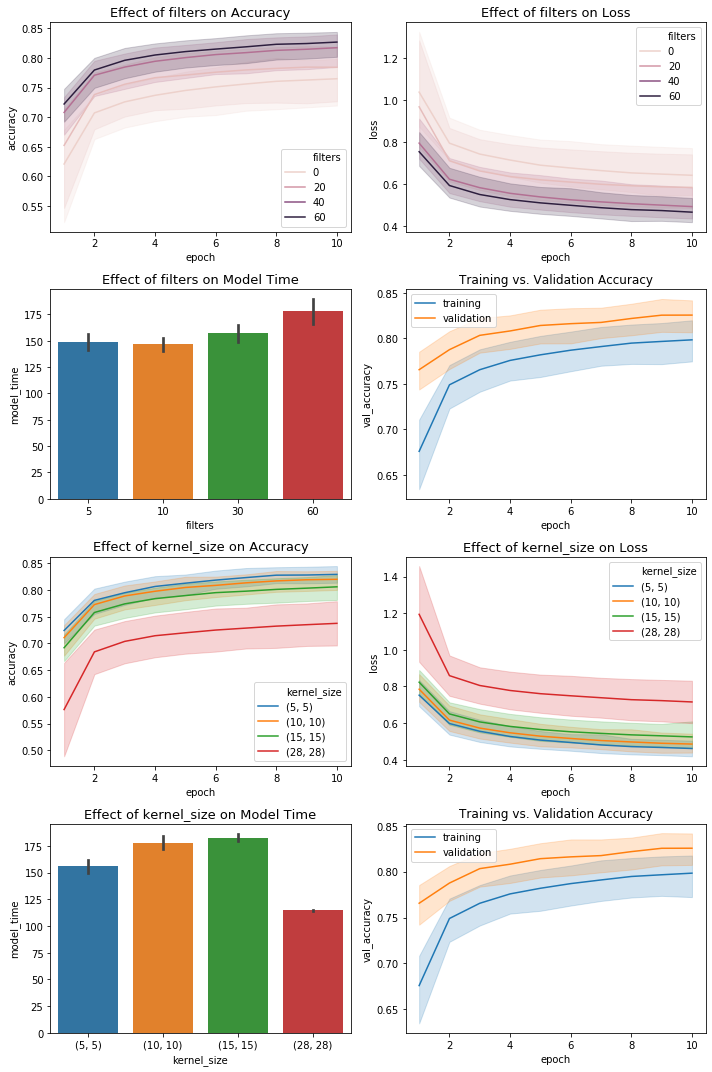

In [232]:
#visualize effects of different parameters on model results and training time
fig, axes = plt.subplots(4,2,figsize=(10,15))
axes = axes.flatten()
for i, metric in enumerate(['filters','kernel_size']):
    sns.lineplot('epoch','accuracy',data=all_results, hue=metric, ax=axes[i*4])
    axes[i*4].set_title('Effect of '+metric+' on Accuracy',size=13)
    sns.lineplot('epoch','loss',data=all_results, hue=metric, ax=axes[i*4+1])
    axes[i*4+1].set_title('Effect of '+metric+' on Loss',size=13)
    sns.barplot(metric,'model_time',data=all_results,ax=axes[i*4+2])
    axes[i*4+2].set_title('Effect of '+metric+' on Model Time',size=13)
    sns.lineplot('epoch','accuracy',data=all_results,ax=axes[i*4+3], label='training')
    sns.lineplot('epoch','val_accuracy',data=all_results,ax=axes[i*4+3], label='validation')
    axes[i*4+3].legend()
    axes[i*4+3].set_title('Training vs. Validation Accuracy')
    plt.tight_layout()

In [245]:
all_results.sort_values('val_accuracy',ascending=False)

,val_loss,val_accuracy,loss,accuracy,epoch,model_time,filters,kernel_size
7,0.363211,0.8708,0.419167,0.845850,8,188.005371,60,"(5, 5)"
9,0.371872,0.8694,0.410544,0.847600,10,188.005371,60,"(5, 5)"
9,0.371004,0.8648,0.428175,0.840500,10,208.400499,60,"(10, 10)"
4,0.386946,0.8633,0.450035,0.832200,5,188.005371,60,"(5, 5)"
8,0.382275,0.8628,0.418420,0.846200,9,188.005371,60,"(5, 5)"
...,...,...,...,...,...,...,...,...
2,0.774770,0.7131,0.915068,0.659783,3,113.831705,5,"(28, 28)"
1,0.789925,0.7080,0.951762,0.647900,2,116.161915,10,"(28, 28)"
1,0.807965,0.6996,0.986650,0.637133,2,113.831705,5,"(28, 28)"
0,0.941992,0.6675,1.461299,0.474533,1,113.831705,5,"(28, 28)"


### 3. Convolutional Neural Nets: Optimization
In this section we add more layers to our model in order to increase validation accuracy. The model architecture is as follows: (Convolutional Layer + Convolutional Layer + Maxpool Layer + Dropout)*2 + (Flatten + Dense + Dropout + Dense). We test the effect of data augmentation by using Keras' image generator to vary our inputs and bolster our model's ability to generalize to unseen data.

This more complex model achieves a validation accuracy of 92% over 10 epochs - compared to the best model in the previous section (one convolutional layer, 60 filters, kernel size of (5,5)) which achieved 84% accuracy on the validation set, we see the additional layers yield an 8% accuracy improvement. Keep in mind that because this is a rather simple input dataset (only 10 possible outputs, grayscale, uniform distribution of categories, objects are similar sizes) the out-of-the-box accuracy with just one layer is already pretty high. With a more complicated input dataset, we would expect to see a greater lift in accuracy from the model with one convolutional layer to the model with multiple.

In [238]:
model_advanced = Sequential([Conv2D(filters=32, kernel_size=(5,5), padding='Same', activation='relu',input_shape=x_train_scaled_shape.shape[1:]),
                   Conv2D(filters=32, kernel_size=(5,5), padding='Same', activation='relu'),
                   MaxPool2D(pool_size=(2,2)),
                   Dropout(0.25),

                   Conv2D(filters=32, kernel_size=(5,5), padding='Same', activation='relu'),
                   Conv2D(filters=32, kernel_size=(5,5), padding='Same', activation='relu'),
                   MaxPool2D(pool_size=(2,2)),
                   Dropout(0.25),

                   Flatten(),
                   Dense(256, activation='relu'),
                   Dropout(0.5),
                   Dense(10, activation='softmax')])

model_advanced.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

model_advanced.summary()
epochs=10
batch_size=100

history_no_aug = model_advanced.fit(x_train_split, y_train_split, batch_size=batch_size, epochs=epochs,
                                  validation_data=(x_val_split, y_val_split), verbose=1)

Model: "sequential_146"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_149 (Conv2D)          (None, 28, 28, 32)        832       
_________________________________________________________________
conv2d_150 (Conv2D)          (None, 28, 28, 32)        25632     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_151 (Conv2D)          (None, 14, 14, 32)        25632     
_________________________________________________________________
conv2d_152 (Conv2D)          (None, 14, 14, 32)        25632     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 32)       

In [239]:
datagen = ImageDataGenerator(featurewise_center=False,
                            samplewise_center=False,
                            featurewise_std_normalization=False,
                            samplewise_std_normalization=False,
                            zca_whitening=False,
                            rotation_range=10,
                            zoom_range=0.1,
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            horizontal_flip=True,
                            vertical_flip=False)
datagen.fit(x_train_split)

history_advanced = model.fit_generator(datagen.flow(x_train_split, y_train_split, batch_size=batch_size),
                                                   epochs=epochs, validation_data=(x_val_split, y_val_split),
                                                   verbose=1, steps_per_epoch=x_train_split.shape[0]//batch_size)

Epoch 1/10
480/480 [==============================] - 12s 24ms/step - loss: 0.6761 - accuracy: 0.7544 - val_loss: 0.4964 - val_accuracy: 0.8123
Epoch 2/10
480/480 [==============================] - 9s 19ms/step - loss: 0.6205 - accuracy: 0.7691 - val_loss: 0.4884 - val_accuracy: 0.8189
Epoch 3/10
480/480 [==============================] - 9s 19ms/step - loss: 0.6064 - accuracy: 0.7763 - val_loss: 0.5020 - val_accuracy: 0.8054
Epoch 4/10
480/480 [==============================] - 9s 19ms/step - loss: 0.6009 - accuracy: 0.7761 - val_loss: 0.4836 - val_accuracy: 0.8176
Epoch 5/10
480/480 [==============================] - 9s 20ms/step - loss: 0.5958 - accuracy: 0.7794 - val_loss: 0.4708 - val_accuracy: 0.8242
Epoch 6/10
480/480 [==============================] - 9s 19ms/step - loss: 0.5887 - accuracy: 0.7822 - val_loss: 0.4776 - val_accuracy: 0.8248
Epoch 7/10
480/480 [==============================] - 9s 19ms/step - loss: 0.5822 - accuracy: 0.7839 - val_loss: 0.4711 - val_accuracy: 0.823

## 3a - why is accuracy worse for model with augmentation?

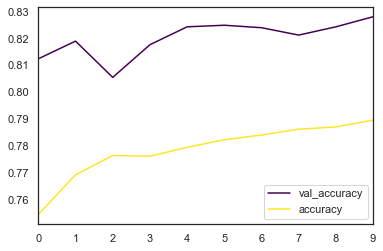

In [254]:
pd.DataFrame(history_advanced.history)[['val_accuracy','accuracy']].plot(cmap='viridis')

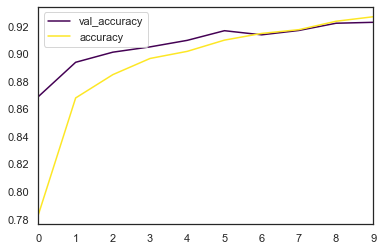

In [255]:
pd.DataFrame(history_no_aug.history)[['val_accuracy','accuracy']].plot(cmap='viridis')

### 4. Visualizing Filters
I thought it would be an interesting exercise to visualize the outputs from each of the convolutional layers (feature maps) to further unpack how a CNN works. Here we display the results of two of the convolutional layers in the model from section 3 to see what the model sees during training. While individual feature maps don't show any striking patterns or shapes, we gain a sense for how the model "thinks" during training. Note that lighter colors represent where each filter was more heavily activated.

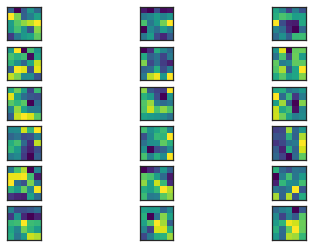

In [527]:
layer_dict = dict([(layer.name, layer) for layer in model_advanced.layers])
layer_name = 'conv2d_331'
filter_index = 0

filters, biases = layer_dict[layer_name].get_weights()

f_min, f_max = np.amin(filters), np.amax(filters)
filters = (filters-f_min)/(f_max-f_min)

n_filters, index = 6,1
for i in range(n_filters):
    f = filters[:,:,:,i]
    
    for j in range(3):
        ax=plt.subplot(n_filters, 3, index)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow(f[:,:,j], cmap='viridis')
        index +=1
plt.show()

### Prediction analysis

In [363]:
#find best model
#best_model = all_results[all_results['accuracy']==all_results['accuracy'].max()]
best_params = {'kernels':(3,3), 'filters':60}
best_model = CNN(best_params)
prediction_model = best_model.create_model()
history = best_model.fit_model(prediction_model)

#calculate predictions
predictions = prediction_model.predict(x_test_scaled_shape)
predicted = [np.argmax(x) for x in predictions]
counter = Counter()
for x,y in list(zip(predicted, y_test)):
    if x==y:
        counter[y]+=1
counter

Epoch 1/3
600/600 [==============================] - 19s 32ms/step - loss: 0.6947 - accuracy: 0.7462 - val_loss: 0.5299 - val_accuracy: 0.8010
Epoch 2/3
600/600 [==============================] - 17s 29ms/step - loss: 0.5387 - accuracy: 0.8007 - val_loss: 0.4689 - val_accuracy: 0.8346
Epoch 3/3
600/600 [==============================] - 17s 28ms/step - loss: 0.5013 - accuracy: 0.8160 - val_loss: 0.4318 - val_accuracy: 0.8467


Counter({9: 933,
         2: 732,
         1: 968,
         6: 540,
         5: 978,
         7: 933,
         4: 773,
         3: 887,
         8: 950,
         0: 773})

In [364]:
pred_df = pd.DataFrame(zip(predicted, y_test)).rename(columns={0:'predicted',1:'actual'})
pred_df['predicted_label'] = pred_df['predicted'].map(categories)
pred_df['actual_label'] = pred_df['actual'].map(categories)
pred_df['correct'] = pred_df['actual'] == pred_df['predicted']
correct = pred_df.groupby('actual_label')[['correct']].sum().sort_values('correct', ascending=False)
display(correct)

wrong = pred_df[pred_df['correct']==False].groupby(['actual_label','predicted_label'])[['correct']].count().sort_values('correct',ascending=False)
top5_wrong = wrong.nlargest(10, 'correct')
display(wrong)

,correct
actual_label,
Sandal,978.0
Trouser,968.0
Bag,950.0
Boot,933.0
Sneaker,933.0
Dress,887.0
Coat,773.0
T-shirt/top,773.0
Pullover,732.0


correct
actual_label predicted_label         
Shirt        T-shirt/top          161
Pullover     Coat                 131
Shirt        Coat                 115
Pullover     Shirt                111
Shirt        Pullover             110
T-shirt/top  Shirt                101
             Dress                 86
Coat         Pullover              85
             Shirt                 82
Shirt        Dress                 65
Coat         Dress                 57
Boot         Sneaker               51
Dress        Shirt                 42
Sneaker      Sandal                40
             Boot                  27
Trouser      Dress                 23
Bag          Shirt                 21
Dress        Trouser               21
Sandal       Sneaker               20
Dress        Coat                  20
             T-shirt/top           19
T-shirt/top  Pullover              15
Boot         Sandal                15
Pullover     T-shirt/top           11
T-shirt/top  Coat                  11
Dress        Pullover              10
Pullover     Dress                 10
T-shirt/top  Bag                    8
Bag          Dress                  6
Shirt        Bag                    6
Trouser      Coat                   5
Bag          T-shirt/top            5
             Coat                   4
             Trouser                4
             Sneaker                4
T-shirt/top  Sandal                 4
Bag          Sandal                 3
Pullover     Trouser                2
Sandal       Boot                   2
Shirt        Trouser                2
Trouser      Pullover               2
Pullover     Bag                    2
T-shirt/top  Trouser                2
Bag          Boot                   2
Trouser      Bag                    1
Pullover     Sandal                 1
Shirt        Sandal                 1
Dress        Bag                    1
Coat         T-shirt/top            1
             Sandal                 1
             Bag                    1
Boot         Bag                    1
Bag          Pullover               1
Trouser      Shirt                  1

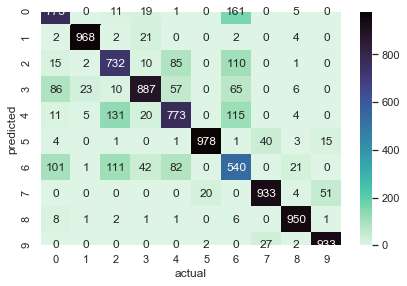

In [518]:
df = pd.DataFrame(y_test).rename(columns={0:'actual'})
df['predicted'] = predicted
df['count'] = 1
df.groupby(['actual','predicted']).count()
df_index = df.reset_index()
pivot = df_index.pivot_table('count',index='predicted',columns='actual',aggfunc='sum')
pivot_nona = pivot.fillna(0)
sns.heatmap(pivot_nona, cmap='mako_r', annot=True, fmt='.0f')

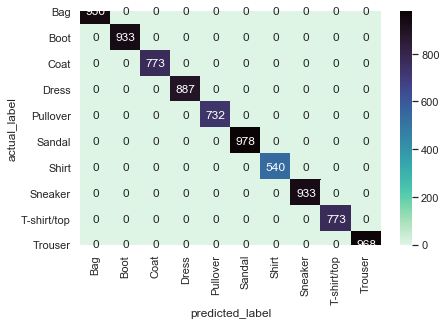

In [515]:
predicted_pivot =pred_df.pivot_table('correct',index='actual_label',columns='predicted_label',aggfunc='sum').fillna(0)
sns.heatmap(predicted_pivot, cmap='mako_r', annot=True, fmt='.0f')

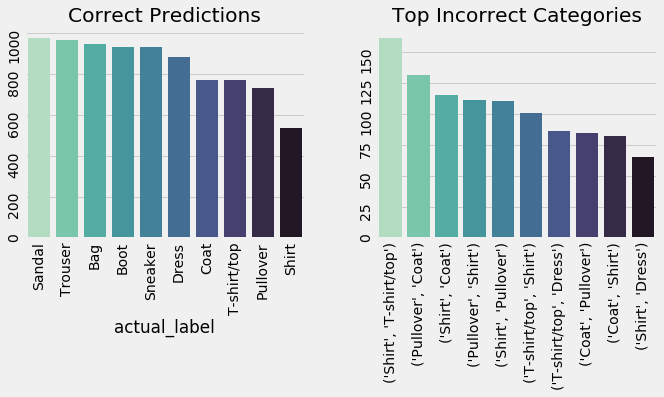

In [383]:
fig, axes = plt.subplots(1,2, figsize=(10, 5))
sns.barplot(correct.index, correct['correct'], ax=axes[0], palette='mako_r')
axes[0].set_title('Correct Predictions')
axes[0].tick_params(labelrotation=90)
axes[0].set_ylabel('')

sns.barplot(top5_wrong.index, top5_wrong['correct'], ax=axes[1], palette='mako_r')
axes[1].set_title('Top Incorrect Categories')
plt.tight_layout()
axes[1].tick_params(labelrotation=90)
y=axes[1].set_ylabel('')

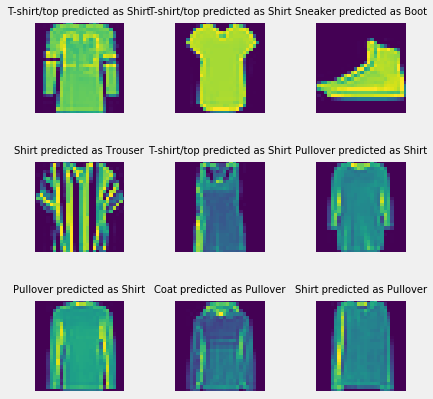

In [385]:
#closer look at shirts, most incorrectly predicted label
#something is very wrong with these labels lol
incorrect = pred_df[pred_df['actual_label']!=pred_df['predicted_label']]
incorrect_indices = incorrect.index

sampling_incorrect = random.choices(incorrect_indices, k=9)
fig, axes = plt.subplots(3,3,figsize=(6,6))
axes = axes.flatten()

for i,index in enumerate(sampling_incorrect):
    actual_label = pred_df.iloc[index]['actual_label']
    predicted_label = pred_df.iloc[index]['predicted_label']
    axes[i].imshow(x_test_scaled[index])
    axes[i].set_title(actual_label +' predicted as '+predicted_label, size=10)
    axes[i].grid(False)
    axes[i].set_xticks([])
    axes[i].set_yticks([])
plt.tight_layout()

In [368]:
#save and load a model
model.save('mnist_fashion.model')
new_model = tf.keras.models.load_model('mnist_fashion.model')